In [1]:
# need to install this manually (since it is not on the pangeo notebook image)
# !mamba install xmip -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.22.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['xmip']

[+] 0.0s
conda-forge/linux-64 ━━━━━━━━━━━━╸━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s

In [2]:
import xmip
xmip.__version__

'0.6.1rc0'

In [3]:
import dask
from distributed import LocalCluster, Client

dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})
cluster = LocalCluster(n_workers=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 58.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40319,Workers: 1
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.88 GiB
Comm: tcp://127.0.0.1:36707,Total threads: 16
Dashboard: /user/jbusecke/proxy/37317/status,Memory: 58.88 GiB
Nanny: tcp://127.0.0.1:35391,


In [4]:
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import match_metrics, pick_first_member
import pandas as pd

In [5]:
from functools import reduce
from tqdm.auto import tqdm
import xarray as xr

def _maybe_make_list(a):
    if isinstance(a,str):
        return [a]
    else:
        return a

def search_and_load_zarr(df, preprocess=combined_preprocessing, **kwargs):
    # parse kwargs to dataframe index list
    filter_list = [df[k].isin(_maybe_make_list(v)) for k,v in kwargs.items()]
    index = reduce(lambda a,b: a & b, filter_list, True)
    df_filtered = df.loc[index]
    stores = df_filtered['zstore'].tolist()
    instance_ids = ['.'.join(s.split('/')[3:-1]) for s in stores]
    ddict = {}
    iter_list = list(zip(instance_ids, stores))
    for iid, sto in tqdm(iter_list):
        try:
            ds = xr.open_zarr(sto, consolidated=True, use_cftime=True)
            # ds = xr.open_dataset(sto, engine='zarr', consolidated=True, use_cftime=True, chunks={'time':3})
            if preprocess:
                ds = preprocess(ds)
            ddict[iid] = ds
        except Exception as e:
            print(f"{iid} failed with {e}")
    return ddict

df = pd.read_csv("https://storage.googleapis.com/cmip6/pangeo-cmip6.csv")

In [24]:
# choosing a subset of models (to reduce the compute time, and some unresolved issues)
source_ids = [
 # 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 # 'AWI-CM-1-1-MR', #unstructured grids
 # 'AWI-ESM-1-1-LR',#unstructured grids
 # 'BCC-CSM2-HR',
 # 'BCC-CSM2-MR',
 # 'BCC-ESM1', #no area
 # 'CAMS-CSM1-0', # no area
 'CAS-ESM2-0',
 # 'CESM1-1-CAM5-CMIP5',
 # 'CESM1-WACCM-SC',
 # 'CESM2',
 # 'CESM2-FV2',
 # 'CESM2-WACCM',
 # 'CESM2-WACCM-FV2',
 # 'CIESM',
 # 'CMCC-CM2-HR4',
 # 'CMCC-CM2-SR5',
 # 'CMCC-CM2-VHR4',
 'CMCC-ESM2',
 # 'CNRM-CM6-1',
 # 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 # 'CanESM5',# something is wrong with the canadian models
 # 'CanESM5-CanOE', # Issue when computing the timeseries (
 # 'E3SM-1-0',
 # 'E3SM-1-1',
 'E3SM-1-1-ECA',
 # 'EC-Earth3', # most members are too short
 # 'EC-Earth3-AerChem',
 # 'EC-Earth3-CC',
 # 'EC-Earth3-LR',
 # 'EC-Earth3-Veg',
 # 'EC-Earth3-Veg-LR',
 # 'EC-Earth3P',
 # 'EC-Earth3P-HR',
 # 'EC-Earth3P-VHR',
 # 'ECMWF-IFS-HR',
 # 'ECMWF-IFS-LR',
 # 'FGOALS-f3-H',
 # 'FGOALS-f3-L',
 'FGOALS-g3',
 # 'FIO-ESM-2-0',
 # 'GFDL-AM4',
 # 'GFDL-CM4',
 # 'GFDL-CM4C192',
 # 'GFDL-ESM2M',
 'GFDL-ESM4',
 # 'GFDL-OM4p5B',
 # 'GISS-E2-1-G', #unresolved issue with metrics for GISS model
 # 'GISS-E2-1-G-CC',
 # 'GISS-E2-1-H',
 # 'GISS-E2-2-G',
 # 'GISS-E2-2-H',
 # 'HadGEM3-GC31-HM',
 # 'HadGEM3-GC31-LL',
 # 'HadGEM3-GC31-LM',
 # 'HadGEM3-GC31-MM', # compute issue
 'ICON-ESM-LR',
 # 'IITM-ESM',
 # 'INM-CM4-8',
 'INM-CM5-0',
 # 'INM-CM5-H',
 # 'IPSL-CM5A2-INCA',
 # 'IPSL-CM6A-ATM-HR',
 'IPSL-CM6A-LR',
 # 'IPSL-CM6A-LR-INCA',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MCM-UA-1-0',
 # 'MIROC-ES2H',
 # 'MIROC-ES2L',
 'MIROC6',
 # 'MPI-ESM-1-2-HAM',
 # 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 # 'MPI-ESM1-2-XR',
 # 'MRI-AGCM3-2-H',
 # 'MRI-AGCM3-2-S',
 'MRI-ESM2-0',
 # 'NESM3', # no area
 # 'NorCPM1',
 # 'NorESM1-F',
 # 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
]

grid_labels = ['gn']
activity_ids = ['CMIP', 'ScenarioMIP']
experiment_ids = [
        'historical',
        'ssp126',
        # 'ssp245',
        # 'ssp370',
        'ssp585'
    ]

data = search_and_load_zarr(
    df,
    source_id=source_ids,
    variable_id='tos',
    activity_id = activity_ids,
    experiment_id=experiment_ids,
    table_id='Omon',
    grid_label='gn',
)
area_data = search_and_load_zarr(
    df,
    source_id=source_ids,
    experiment_id = experiment_ids + ['piControl'],
    variable_id='areacello',
    table_id='Ofx',
    grid_label='gn',
)

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

## xMIP: Match cell area to datasets

In [25]:
data_with_metrics = match_metrics(
    data,
    area_data,
    ['areacello'],
    print_statistics=True
)

Processed 333 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 333}
No match found:{'areacello': 0}


## xMIP: Pick only one member to speed things up

In [26]:
data_first = pick_first_member(data_with_metrics)

## Create averaged timeseries

In [27]:
data_timeseries = {}
for k,ds in data_first.items():
    
    # debug version
    print(k)
#     area = ds.areacello.load().fillna(0)
#     tos = ds.tos
    
#     timeseries = tos.weighted(area).mean(['x','y']).load()
#     print(timeseries)
#     print(timeseries.nbytes/1e9)
#     print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    # one liner for the demo
    timeseries = ds.tos.weighted(ds.areacello.fillna(0)).mean(['x', 'y']).load()
    timeseries.attrs = {k:v for k,v in ds.attrs.items()}
    
    data_timeseries[k] = timeseries

GFDL-ESM4.gn.historical.Omon.tos
GFDL-ESM4.gn.ssp585.Omon.tos
GFDL-ESM4.gn.ssp126.Omon.tos
IPSL-CM6A-LR.gn.historical.Omon.tos
CNRM-ESM2-1.gn.historical.Omon.tos
MIROC6.gn.historical.Omon.tos
SAM0-UNICON.gn.historical.Omon.tos
CNRM-ESM2-1.gn.ssp126.Omon.tos
CNRM-ESM2-1.gn.ssp585.Omon.tos
IPSL-CM6A-LR.gn.ssp126.Omon.tos
MIROC6.gn.ssp126.Omon.tos
MIROC6.gn.ssp585.Omon.tos
MPI-ESM1-2-LR.gn.ssp126.Omon.tos
MPI-ESM1-2-LR.gn.historical.Omon.tos
MPI-ESM1-2-LR.gn.ssp585.Omon.tos
MCM-UA-1-0.gn.historical.Omon.tos
MCM-UA-1-0.gn.ssp585.Omon.tos
MCM-UA-1-0.gn.ssp126.Omon.tos
IPSL-CM6A-LR.gn.ssp585.Omon.tos
MRI-ESM2-0.gn.historical.Omon.tos
FGOALS-g3.gn.historical.Omon.tos
MRI-ESM2-0.gn.ssp126.Omon.tos
MRI-ESM2-0.gn.ssp585.Omon.tos
NorESM2-MM.gn.ssp126.Omon.tos
NorESM2-MM.gn.ssp585.Omon.tos
NorESM2-MM.gn.historical.Omon.tos
ACCESS-ESM1-5.gn.historical.Omon.tos
FGOALS-g3.gn.ssp126.Omon.tos
FGOALS-g3.gn.ssp585.Omon.tos
TaiESM1.gn.historical.Omon.tos
CAS-ESM2-0.gn.ssp585.Omon.tos
CAS-ESM2-0.gn.ssp126.

## Concatenate experiments into xarray datasets

In [28]:
# debug version
timeseries_hist_datasets = []
timeseries_ssp126_datasets = []
timeseries_ssp585_datasets = []

for k,ds in data_timeseries.items():
    # Separate experiments
    out = ds.convert_calendar('standard')
    out = out.sel(time=slice('1850', '2100')) # cut extended runs
    out = out.assign_coords(source_id=ds.source_id)
    if ds.experiment_id == 'historical':
        timeseries_hist_datasets.append(out)
    elif ds.experiment_id == 'ssp126':
        timeseries_ssp126_datasets.append(out)
    elif ds.experiment_id == 'ssp585':
        timeseries_ssp585_datasets.append(out)            

concat_kwargs = dict(
    dim='source_id',
    join='override',
    compat='override',
    coords='minimal'
) 
timeseries_hist = xr.concat(timeseries_hist_datasets, **concat_kwargs)
timeseries_ssp126 = xr.concat(timeseries_ssp126_datasets, **concat_kwargs)
timeseries_ssp585 = xr.concat(timeseries_ssp585_datasets, **concat_kwargs)

# use only models that have all three experiments
timeseries_hist, timeseries_ssp126, timeseries_ssp585 = xr.align(
    timeseries_hist, timeseries_ssp126, timeseries_ssp585, 
    join='inner', exclude=['time'],
)

## Calculate anomaly to base period (1950-1980)

In [29]:
base_period = timeseries_hist.sel(time=slice('1950','1980')).mean('time')
hist = (timeseries_hist - base_period).rolling(time=12).mean()
ssp126 = (timeseries_ssp126 - base_period).rolling(time=12).mean()
ssp585 = (timeseries_ssp585 - base_period).rolling(time=12).mean()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


([<matplotlib.lines.Line2D at 0x7f1207fbaf70>],
 [<matplotlib.collections.PolyCollection at 0x7f11e541b7f0>])

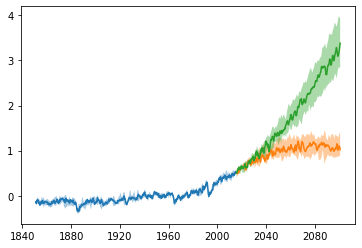

In [33]:
from xarrayutils.plotting import shaded_line_plot
plot_kwargs = dict(spread_style='quantile', spreads=[0.5])

shaded_line_plot(hist, 'source_id', **plot_kwargs)
shaded_line_plot(ssp126, 'source_id', **plot_kwargs)
shaded_line_plot(ssp585, 'source_id', **plot_kwargs)